In [1]:
import torch
import clip
import os
import random
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nltk.corpus import wordnet as wn
from torchvision.datasets import CIFAR100, ImageNet
from google_images_search import GoogleImagesSearch
import PIL
import cv2
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
def get_similarities(images, texts):
    scores = []
    for image in images:
#         print(type(image))
        with torch.no_grad():
            image = preprocess(image).unsqueeze(0).to(device)
            image_features = model.encode_image(image)
            text_features = model.encode_text(texts)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        scores.append(similarity)
    return scores

In [3]:
def load_images(dir_path):
    dir_path = dir_path.replace(' ', '_')
    print(dir_path)
    images = []
    for file in os.listdir(dir_path):
        try:
            images.append(Image.open(dir_path+'/'+file, 'r'))
        except PIL.UnidentifiedImageError as e:
            print(dir_path+'/'+file)
    return images

In [4]:
def get_scores(queries, text_probes=None):
    images = dict([(q, load_images(image_dir+'/'+q)) for q in queries])
    if text_probes is None:
        text_probes = ["a photo of an "+q for q in queries]
    text_probes = torch.cat([clip.tokenize(text) for text in text_probes]).to(device)
    scores= dict([])
    for q, imgs in images.items():
        scores[q] = get_similarities(imgs, text_probes) 
    return scores

In [5]:
image_dir = './images_google_search'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, preprocess = clip.load('ViT-B/32', device)

In [7]:
queries = ["apple logo", "apple fruit"]
images = dict([(q, load_images(image_dir+'/'+q)) for q in queries])
text_probes = ["a drawing of the Apple logo", "a photo of an apple fruit"]
if text_probes is None:
    text_probes = ["a photo of an "+q for q in queries]
pre_imgs = []
orig_imgs = []
for q, imgs in images.items():
    with torch.no_grad():
        for img in imgs:
            orig_imgs.append(img)
            pre_imgs.append(preprocess(img).to(device))
pre_imgs = torch.stack(pre_imgs)

./images_google_search/apple_logo
./images_google_search/apple_fruit


In [8]:
def reshape_transform(tensor, height=7, width=7):
    tensor = tensor.transpose(0,1)
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

class VisualModel(torch.nn.Module):
    def __init__(self, text_probes, device):
        super(VisualModel, self).__init__()
        self.device = device
        self.text_probes = torch.cat([clip.tokenize(text) for text in text_probes]).to(self.device)
        self.clip_model, _ = clip.load('ViT-B/32', self.device)
        
    def forward(self, imgs):
        logits, _ = self.clip_model(imgs, self.text_probes)
        return logits

In [13]:
model = VisualModel(text_probes, device).to(device)
cam = GradCAMPlusPlus(model=model, target_layer=model.clip_model.visual.transformer.resblocks[-2].ln_1, reshape_transform=reshape_transform, use_cuda=True)

In [18]:
grayscale_cam = cam(input_tensor=pre_imgs, target_category=0)

/fs/classhomes/fall2021/cmsc828w/cs828w04/anaconda3/lib/python3.8/site-packages/pytorch_grad_cam/grad_cam_plusplus.py:21: RuntimeWarning: divide by zero encountered in true_divide
  aij = grads_power_2 / (2*grads_power_2 +
/fs/classhomes/fall2021/cmsc828w/cs828w04/anaconda3/lib/python3.8/site-packages/pytorch_grad_cam/base_cam.py:86: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)


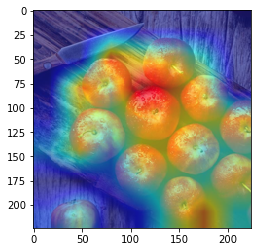

In [43]:
ind = 62
inp_img = pre_imgs[ind].transpose(0,1).transpose(1,2).cpu().numpy()
inp_img = (inp_img - inp_img.min())/(inp_img.max() - inp_img.min())
grad_pics = show_cam_on_image(inp_img, grayscale_cam[ind,:], use_rgb=True)

from matplotlib import pyplot as plt
plt.imshow(grad_pics, interpolation='nearest')
plt.show()

In [12]:
model.clip_model.visual.transformer.resblocks

Sequential(
  (0): ResidualAttentionBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (c_fc): Linear(in_features=768, out_features=3072, bias=True)
      (gelu): QuickGELU()
      (c_proj): Linear(in_features=3072, out_features=768, bias=True)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (1): ResidualAttentionBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (c_fc): Linear(in_features=768, out_features=3072, bias=True)
      (gelu): QuickGELU()
      (c_proj): Linear(in_features=3072, out_features=768, bias=True)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )


In [ ]:
scores = get_scores(queries, text_probes=text_probes)
predictions = np.array([np.bincount([int(s.argmax()) for s in scores[q]], minlength=len(queries)) for q in queries])